## Predicting Credit Risk for Bank

<font size=3> This project makes use of logistic regression, a classification model (supervised machine learning model) to predict a particular customer's credit risk. 
    
We make the assumption that the cost of issuing a loan to a customer with high risk, is five times that of denying a loan to a customer with low risk.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Loading dataset and placing it into a dataframe
credit = pd.read_csv('German_Credit.csv')

print(credit.shape)

# This code displays all columns
pd.set_option('display.max_columns', None)
display(credit.head())

(1000, 22)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,other_signators,time_in_residence,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,none,2,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,none,3,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,guarantor,4,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,none,4,unknown-none,53,none,for free,2,skilled,2,none,yes,1


<font size=3>Of the 22 columns, 1 is customer identifier column (customer_id), 20 are features and 1 is a label column (bad_credit).

In [3]:
# Checking for class imbalance
credit_counts = credit[['credit_history', 'bad_credit']].groupby('bad_credit').count()
print(credit_counts)

            credit_history
bad_credit                
0                      700
1                      300


In [4]:
# Create a numpy array of label values (i.e. column titled 'bad_credit')
labels = np.array(credit['bad_credit'])
labels

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,

In [5]:
# One-hot encode selected categorical variables which contain nominal data, into numerical data

def encode_string(cat_features):
 
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['credit_history', 'purpose', 'gender_status', 
                       'time_in_residence', 'property']

Features = encode_string(credit['checking_account_status'])
for col in categorical_columns:
    temp = encode_string(credit[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(1000, 31)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0.]]


<font size=4>Next the numeric features must be concatenated to the numpy array by executing the code in the cell below. 

In [6]:
# Concatenate encoded categorical variables with numerical variables
Features = np.concatenate([Features, np.array(credit[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']])], axis = 1)
print(Features.shape)
print(Features[:2, :])   

(1000, 35)
[[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 6.000e+00 1.169e+03 4.000e+00 6.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 4.800e+01 5.951e+03 2.000e+00 2.200e+01]]


In [7]:
# Split data into training and test data sets where training set has 700 rows of data and test set has 300 rows.
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

In [8]:
# Scale numerical data to (Z-score scale) so that data will be in a similar range and higher importance will not be conferred to columns with larger range of values
# Scaler is only used on training data
scaler = preprocessing.StandardScaler().fit(X_train[:,31:])
X_train[:,31:] = scaler.transform(X_train[:,31:])
X_test[:,31:] = scaler.transform(X_test[:,31:])
X_train[:2,]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.53154035,  0.62707145, -0.86525095, -0.93382362],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.27037074,  1.65067659, -1.

In [9]:
# Construct the logistic regression model
logistic_mod = linear_model.LogisticRegression(max_iter=1000) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [10]:
# Obtain the model coefficients
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

[-0.55913985]
[[ 0.19846303  0.93617114 -0.11259824 -1.02222806  0.53330439 -0.96441822
  -0.25740363  0.91100636 -0.22268102  0.06356988  0.62419289 -0.51091859
   0.29118816  0.27810232  0.14503389 -0.44298374 -0.28398756  0.19639902
  -0.36078838  0.08146493  0.23727233  0.09724962 -0.41617901 -0.36638268
   0.40725783 -0.17863148  0.13756422 -0.07780448  0.09474882 -0.33716583
   0.32002937  0.27237073  0.18088435  0.25423605 -0.18171383]]


<font size=3>Nearly all the coefficients have the same magnitude indicating this model is likely to be overfit, given the number of features. 

In [11]:
# Compute a sample of class probabilities for the test feature set
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

[[0.84681629 0.15318371]
 [0.40257297 0.59742703]
 [0.94359534 0.05640466]
 [0.31580645 0.68419355]
 [0.55073035 0.44926965]
 [0.97548673 0.02451327]
 [0.94935223 0.05064777]
 [0.62315898 0.37684102]
 [0.87530439 0.12469561]
 [0.9271592  0.0728408 ]
 [0.56872575 0.43127425]
 [0.40185487 0.59814513]
 [0.50475289 0.49524711]
 [0.67690928 0.32309072]
 [0.35000049 0.64999951]]


<font size=3>The first column is the probability of a score of $0$ and the second column is the probability of a score of $1$. Notice that for most, but not all cases, the probability of a score of $0$ is higher than $1$.


In [12]:
# Transform probabilities into classification and compare a sample of results
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


<font size=3>Some of the positive ($1$) predictions are the same as the test labels in the second row. However, Some are not.

<font size=3>Make use of the confusion matrix to examine the correctly and incorrectly classified cases in a tabular format. 

**Confusion matrix**

| | Labelled Positive | Labelled Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Actual Negative**| False Positive | True Negative |   


In [13]:
# Computing performance of logistic regression model
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores,zero_division=0)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
Actual positive       183                29
Actual negative        39                49

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.82          0.63
Recall       0.86          0.56
F1           0.84          0.59


<font size=3>Observations:
1. The confusion matrix shows the following characteristics:
- Most of the positive cases are correctly classified (182 correct vs. 30 incorrect)
- Many negative cases are incorrectly classified (48 correct, vs. 40 incorrect)

2. The overall accuracy is 0.77
- Accuracy is not a good metric to use in this case as it does not look at accuracy of positive and negative cases separately.

3. The class imbalance is confirmed. Of the 300 test cases 212 are positive and 88 are negative.

    
4. The precision, recall and F1 all show that positive cases are classified reasonably well, but the negative cases are not, with a much lower score. 

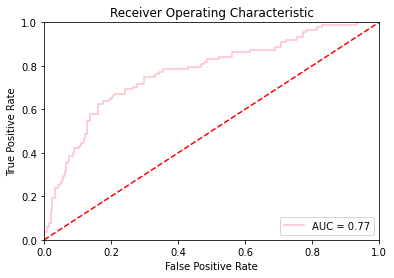

In [14]:
# Plotting ROC curve and computing AUC
# fpr refers to false positive rate and tpr refers to true positive rate
def plot_auc(labels, probs):
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'pink', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities)    

<font size=3>Observations: The ROC curve is above the diagonal red-dotted line which implies that is is greater than AUC of 0.5. Specifically, the AUC is 0.77. However, given the class imbalance, this may not be a good enough score. 

In [15]:
# Use for loop to identify better threshold
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.6
                 Confusion matrix
                 Score positive    Score negative
Actual positive       196                16
Actual negative        54                34

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.78          0.68
Recall       0.92          0.39
F1           0.85          0.49

For threshold = 0.55
                 Confusion matrix
                 Score positive    Score negative
Actual positive       187                25
Actual negative        48                40

Accuracy  0.76
 
           Positive      Negative
Num case      212            88
Precision    0.80          0.62
Recall       0.88          0.45
F1           0.84          0.52

For threshold = 0.5
                 Confusion matrix
                 Score positive    Score negative
Actual positive       183                29
Actual negative        39                49

Accuracy  0.77
 
           Positive      Negative
Num case

<font size=3>Note that as the threshold is decreases, the number of correctly classified negative cases (bad credit customers) increases at the expense of correctly classifying positive cases (good credit customers). At the same time, accuracy decreases. However, as mentioned earlier, accuracy is not a particularly useful metric here. 

Exactly which threshold to pick is a business decision.